# Compare models in SVD, PMF and Logistic PMF


In [1]:
from recom.datasets import load_ml_small_rating

# load data
dataset = load_ml_small_rating(need_raw=True)

# load features
ratings = dataset['raw']
ratings_train_dict = dataset['train_dict']
ratings_test_dict = dataset['test_dict']
n_user = dataset['n_user']
n_item = dataset['n_item']
user2ix = dataset['user2ix']
ix2user = dataset['ix2user']
item2ix = dataset['item2ix']
ix2item = dataset['ix2item']

del dataset

print(f'Users: {n_user}, Items: {n_item}. Sparsity: {round(1-len(ratings)/n_user/n_item, 4)}')
print(f'User reduced from {len(user2ix.keys())} to {len(ratings_train_dict.keys())}')

Users: 610, Items: 9724. Sparsity: 0.983
User reduced from 610 to 607


In [3]:
from recom.model.MF import FunkSvd, PMF, LogisticPMF
from torch import optim
import warnings
warnings.filterwarnings("ignore")

k_dim = 64
n_epochs = 256
use_cuda = True
report_interval = 32
user_per_ep = 256
item_per_ep = 128

""" 1. FunkSVD """
# init model
fsvd = FunkSvd(
    n_user=n_user
    , n_item=n_item
    , k_dim=k_dim
)
# define optimizer
opt = optim.SGD(fsvd.parameters(), lr=0.1, weight_decay=0.01, momentum=0.01)
# train model on gpu, with data and optimizer
fsvd.fit(ratings_train_dict, opt, user_per_ep=user_per_ep, item_per_ep=item_per_ep, n_epochs=n_epochs, use_cuda=use_cuda, report_interval=report_interval)
# return model to cpu
fsvd = fsvd.to('cpu')


""" 2. PMF """
# init model
pmf = PMF(
    n_user=n_user
    , n_item=n_item
    , k_dim=k_dim
    , std_user=1
    , std_item=1
)
# define optimizer
opt = optim.SGD(pmf.parameters(), lr=0.1, weight_decay=0.01, momentum=0.01)
# train model on gpu, with data and optimizer
pmf.fit(ratings_train_dict, opt, user_per_ep=user_per_ep, item_per_ep=item_per_ep, n_epochs=n_epochs, use_cuda=use_cuda, report_interval=report_interval)
# return model to cpu
pmf = pmf.to('cpu')


""" 3. LogisticPMF """
# init model
lpmf = LogisticPMF(
    n_user=n_user
    , n_item=n_item
    , k_dim=k_dim
    , std_user=1
    , std_item=1
)
# define optimizer
opt = optim.SGD(lpmf.parameters(), lr=0.1, weight_decay=0.01, momentum=0.01)
# train model on gpu, with data and optimizer
lpmf.fit(ratings_train_dict, opt, user_per_ep=user_per_ep, item_per_ep=item_per_ep, n_epochs=n_epochs, use_cuda=use_cuda, report_interval=report_interval)
# return model to cpu
lpmf = lpmf.to('cpu')


from recom.eval.evaluator import generate_testing_candidates

# init testing candidates
cand_test = generate_testing_candidates(ratings_train_dict, ix2item)

# predict result
fsvd_pred_results = fsvd.pred_on_candidate_dict(cand_test)
pmf_pred_results = pmf.pred_on_candidate_dict(cand_test)
lpmf_pred_results = lpmf.pred_on_candidate_dict(cand_test)

Epoch: 32, Time: 19.62, /Average loss 14.64221
Epoch: 64, Time: 19.56, /Average loss 14.64545
Epoch: 96, Time: 21.61, /Average loss 14.49591
Epoch: 128, Time: 20.84, /Average loss 14.9682
Epoch: 160, Time: 17.67, /Average loss 14.33752
Epoch: 192, Time: 16.49, /Average loss 14.79944
Epoch: 224, Time: 16.37, /Average loss 14.8938
Epoch: 256, Time: 21.44, /Average loss 14.48718
Epoch: 32, Time: 63.42, /Average loss 11.6196
Epoch: 64, Time: 17.49, /Average loss 11.45842
Epoch: 96, Time: 17.79, /Average loss 11.53125
Epoch: 128, Time: 17.78, /Average loss 11.26777
Epoch: 160, Time: 17.67, /Average loss 11.96578
Epoch: 192, Time: 17.61, /Average loss 11.27726
Epoch: 224, Time: 17.71, /Average loss 11.67954
Epoch: 256, Time: 18.56, /Average loss 11.64405
Epoch: 32, Time: 18.44, /Average loss 0.0975
Epoch: 64, Time: 18.79, /Average loss 0.09339
Epoch: 96, Time: 42.0, /Average loss 0.09886
Epoch: 128, Time: 54.65, /Average loss 0.10198
Epoch: 160, Time: 19.97, /Average loss 0.09922
Epoch: 192,

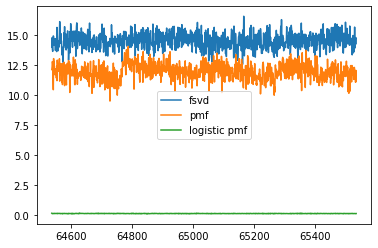

In [4]:
loss_fsvd = fsvd.last_train_loss
loss_pmf = pmf.last_train_loss
loss_lpmf = lpmf.last_train_loss

import matplotlib.pyplot as plt

plt.plot(list(range(len(loss_fsvd)))[-1000:], loss_fsvd[-1000:])
plt.plot(list(range(len(loss_pmf)))[-1000:], loss_pmf[-1000:])
plt.plot(list(range(len(loss_lpmf)))[-1000:], loss_lpmf[-1000:])

plt.legend(['fsvd', 'pmf', 'logistic pmf'])
plt.show()

(0.0, 0.09884678747940692, 0.11367380560131796, 0.13673805601317957, 0.15815485996705106, 0.17792421746293247, 0.19439868204283361, 0.2026359143327842, 0.214168039538715, 0.22405271828665568, 0.24217462932454695, 0.2487644151565074, 0.25370675453047775, 0.2553542009884679, 0.26194398682042835)
(0.0, 0.24052718286655683, 0.3673805601317957, 0.4497528830313015, 0.4843492586490939, 0.515650741350906, 0.5453047775947282, 0.5683690280065898, 0.5897858319604613, 0.6194398682042833, 0.6392092257001647, 0.6556836902800659, 0.6688632619439868, 0.6869851729818781, 0.6985172981878089)
(0.0, 0.09884678747940692, 0.11367380560131796, 0.13673805601317957, 0.15815485996705106, 0.17792421746293247, 0.19439868204283361, 0.2026359143327842, 0.214168039538715, 0.22405271828665568, 0.24217462932454695, 0.2487644151565074, 0.25370675453047775, 0.2553542009884679, 0.26194398682042835) 

(0.0, 0.09884678747940692, 0.10820159436926377, 0.1213811660331847, 0.1306048814449707, 0.1395273514635598, 0.147156170956

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


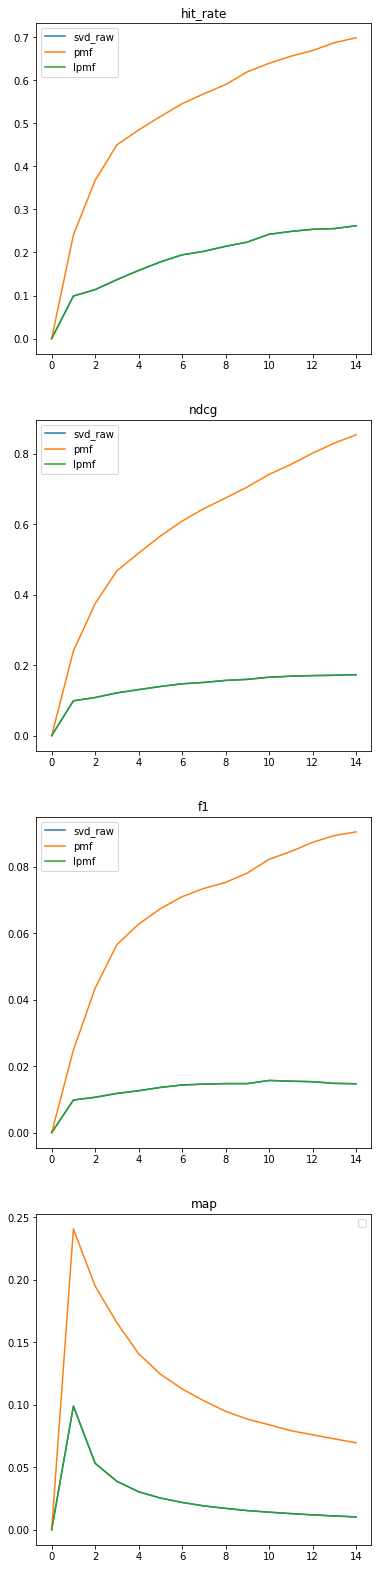

In [5]:
from recom.eval.metrics import hit_rate, ndcg, map, f1
import matplotlib.pyplot as plt

k = 15

metrics = {
    'hit_rate': hit_rate
    , 'ndcg': ndcg
    , 'f1': f1
    , 'map': map
}

preds = {
    'svd_raw': fsvd_pred_results
    , 'pmf': pmf_pred_results
    , 'lpmf': lpmf_pred_results
}

fig, ax = plt.subplots(4, figsize=(6, 28))
for i, m_i in enumerate(metrics.keys()):
    val = [[metrics[m_i](ki, ratings_test_dict, pred) \
            for pred in preds.values()] \
           for ki in range(k)]
    val1, val2, val3 = zip(*val)
    print(val1)
    print(val2)
    print(val3, '\n')
    ax[i].plot(list(range(k)), val)
    ax[i].legend(list(preds.keys()))
    ax[i].set_title(m_i)

plt.legend()
plt.show()